# Define the region to use along the Dutch coast for the Ocean Dynamic Sea Level

We define a region representing sea level along the Dutch coast which we then use to mask datasets of interest:
- Satellite altimetry
- SODA ocean reanalysis
- CMIP6 ocean models

There are different ways to define regions from polygones for xarray datasets.
- Use clip from the [rioxarray package](https://corteva.github.io/rioxarray/stable/examples/clip_geom.html)
- Use the [regionmask package](https://regionmask.readthedocs.io/en/stable/notebooks/create_own_regions.html)

It seems easier to use the regionmask package so this is what we will use here.

In [22]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import matplotlib.pyplot as plt

import regionmask

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')


## Define the region using a polygone

In [2]:
# Narrow region that doesn't contain enough points for CMIP models
#NL = np.array([[3.1, 51.9], [3.3, 51.5], [4.25, 52.25], [4.75, 53.3], [5.5, 53.6], [7, 53.75], [7, 54.3], [4.5, 53.8]])

# Wider region
NL = np.array([[2.5, 53], [3.3, 51.5], [4.25, 52.25], [4.75, 53.3], [5.5, 53.6], [7, 53.75], [7, 55], [4, 54.5]])

NLregion = regionmask.Regions([NL], names=['NL'], abbrevs=['NL'])

NLregion

<regionmask.Regions>
Name:     unnamed
overlap:  False

Regions:
0 NL NL

[1 regions]

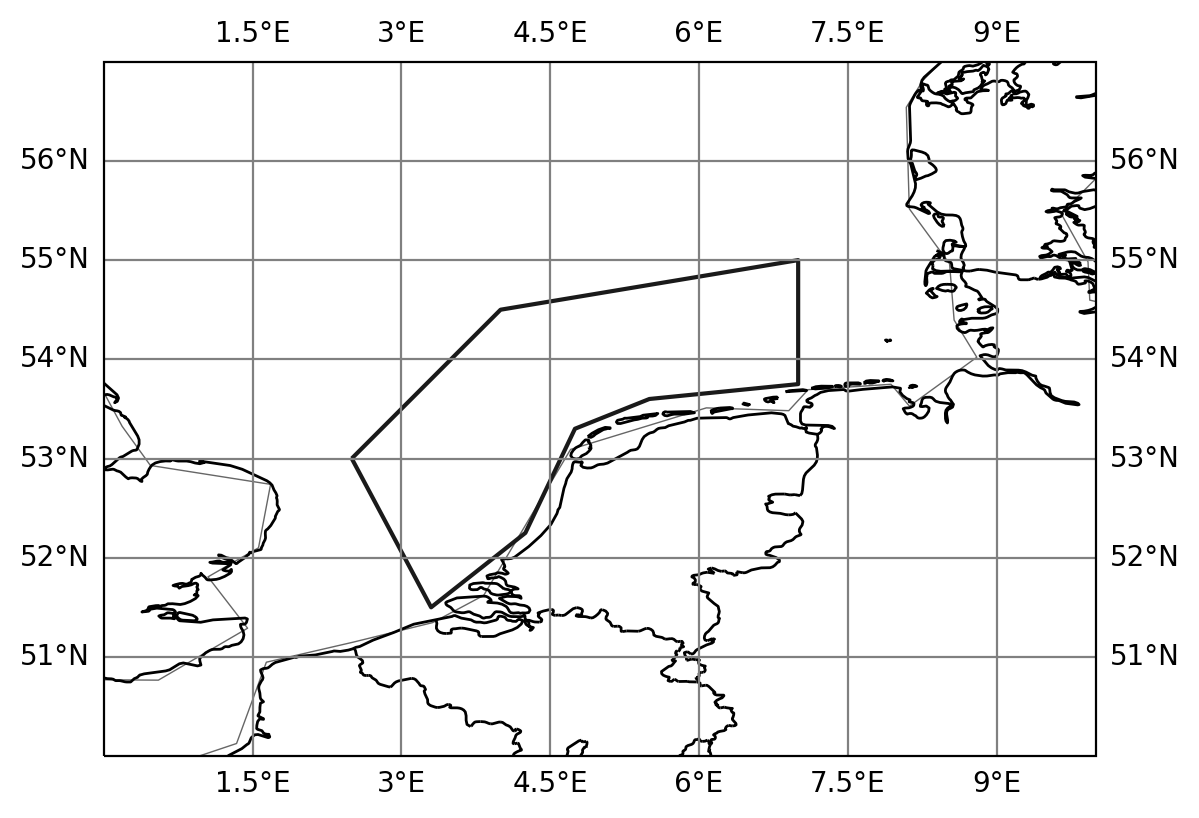

In [3]:
ax = NLregion.plot(add_label=False)

ax.axes.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
ax.set_extent([0, 10, 50, 57], crs=ccrs.PlateCarree() )

#ax.projection(ccrs.LambertAzimuthalEqualArea(central_longitude=5, central_latitude=53))

## Apply the region to AVISO data

In [4]:
def rotate_longitude(ds, name_lon):

    ds = ds.assign_coords({name_lon:(((ds[name_lon] + 180 ) % 360) - 180)})
    ds = ds.sortby(ds[name_lon])

    return ds

In [5]:
# Input data
duacs_dir = '~/Data/duacs_cmems/'

duacs_ds = xr.open_mfdataset(f'{duacs_dir}cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1M-m_*.nc').load()
duacs_ds = rotate_longitude(duacs_ds, 'longitude')
duacs_ds['sla'] = duacs_ds.sla*100 # Convert from meter to cm

duacs_y_ds = duacs_ds.groupby('time.year').mean()

coef = duacs_y_ds.sla.polyfit(dim='year', deg=1, full=False)
cm2mm = 10 # Convert from cm to mm 
rate = (coef*cm2mm).polyfit_coefficients.sel(degree=1)

/Users/dewilebars/anaconda3/envs/p310ds/lib/python3.9/site-packages/xarray/core/nputils.py:171: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


In [6]:
duacs_ds


<xarray.Dataset>
Dimensions:    (time: 348, latitude: 720, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time       (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2021-12-15
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    sla        (time, latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes: (12/43)
    Conventions:                                    CF-1.6
    FROM_ORIGINAL_FILE__Metadata_Conventions:       Unidata Dataset Discovery...
    cdm_data_type:                                  Grid
    comment:                                        Monthly Mean of Sea Level...
    contact:                                        servicedesk.cmems@mercato...
    creator_email:                                  servicedesk.cmems@mercato...
    ...                                             ...
    time_coverage_duration:                         P1M
    time_coverage_end:                              2022-01-31T00:00:00Z
    time_coverage_resolution:                       P1M
    time_coverage_start:                            2022-01-01T00:00:00Z
    title:                                          DT merged all satellites ...
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

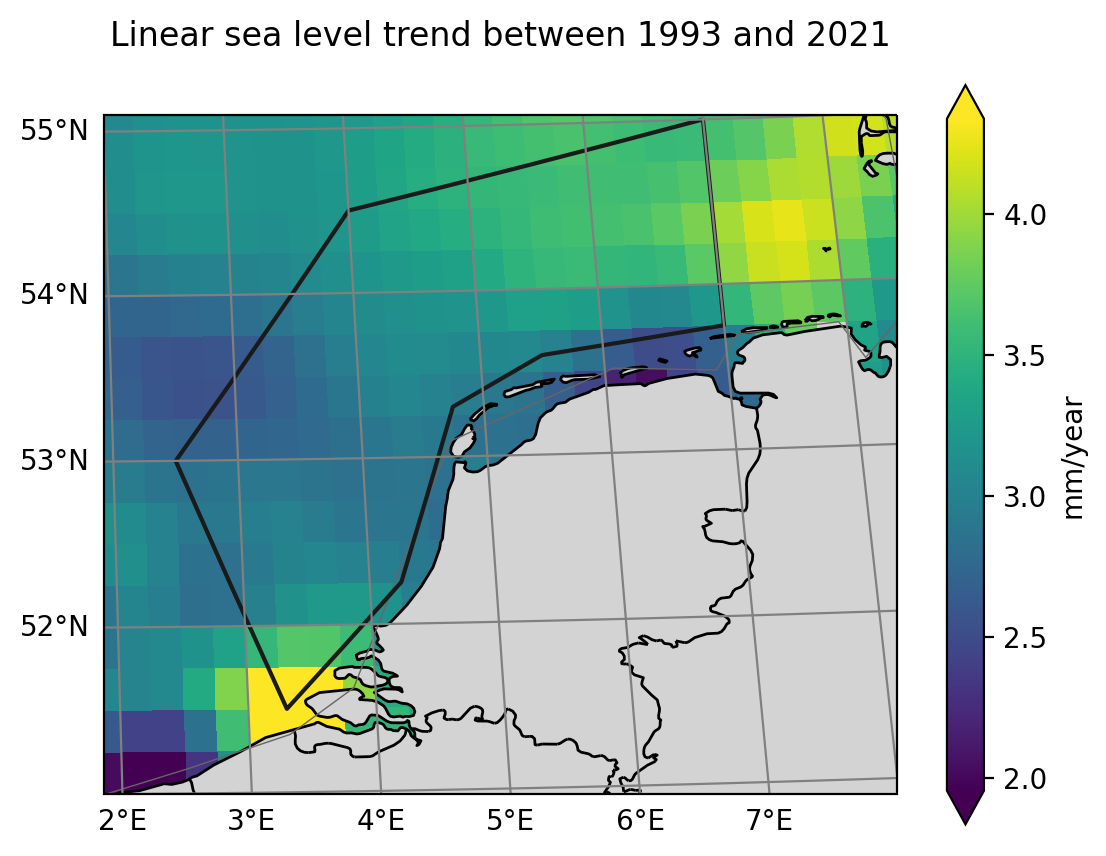

In [7]:
lon_min, lon_max, lat_min, lat_max = 2, 8, 51, 55

p = rate.sel(longitude=slice(lon_min-1,lon_max+1), 
             latitude=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'mm/year'},
    robust=True,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Linear sea level trend between 1993 and 2021', pad=25)

plt.savefig(f'TrendAltimetry_Netherlands.pdf' ,dpi=150)

In [8]:
# Define the mask
mask_alti = NLregion.mask_3D(rate.longitude, rate.latitude)


Text(0.5, 1.0, 'Linear sea level trend between 1993 and 2021')

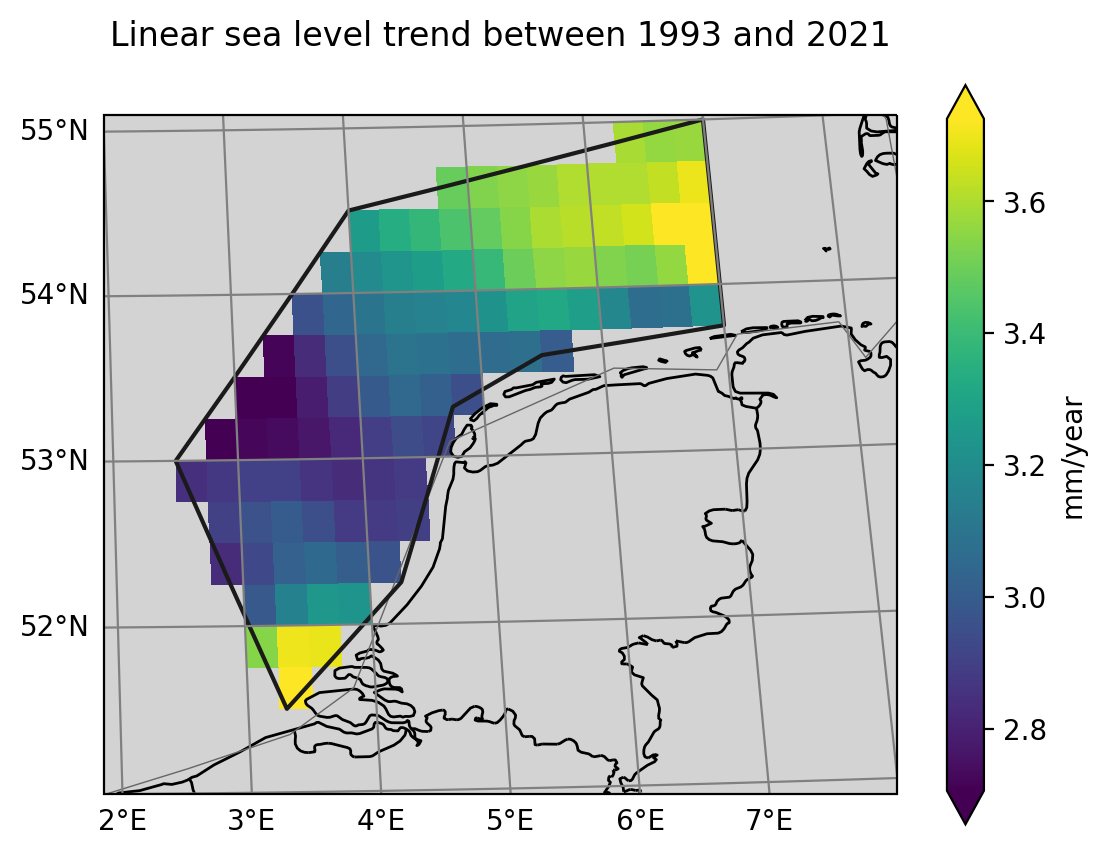

In [9]:
rate_m = rate.where(mask_alti)

p = rate_m.sel(longitude=slice(lon_min-1,lon_max+1), 
             latitude=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'mm/year'},
    robust=True,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Linear sea level trend between 1993 and 2021', pad=25)

Count the number of grid boxes in the region

In [10]:
rate_m.count().values.item()

106

## Apply the region to CMIP6 data

In [11]:
def read_zos_ds(data_dir, mip, sce):
    '''Read both historical and scenario datasets, select the intersecting 
    models and concatenate the two datasets'''
    
    hist_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zos_historical/{mip}_zos_historical_*.nc')
    sce_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zos_{sce}/{mip}_zos_{sce}_*.nc')

    model_intersection = list(set(hist_ds.model.values) & 
                              set(sce_ds.model.values))
    model_intersection.sort()
    tot_ds = xr.concat([hist_ds,sce_ds],'time').sel(model=model_intersection)
    
    return tot_ds

In [12]:
cmip_data_dir = '~/Projects/Project_ProbSLR/Data_Proj/Data_cmip6'

cmip6_245_zos = read_zos_ds(cmip_data_dir, 'cmip6', 'ssp245')

In [13]:
ECE3_245_zos = cmip6_245_zos.CorrectedReggrided_zos.sel(model='EC-Earth3').isel(time=0)

Text(0.5, 1.0, 'Linear sea level trend between 1993 and 2021')

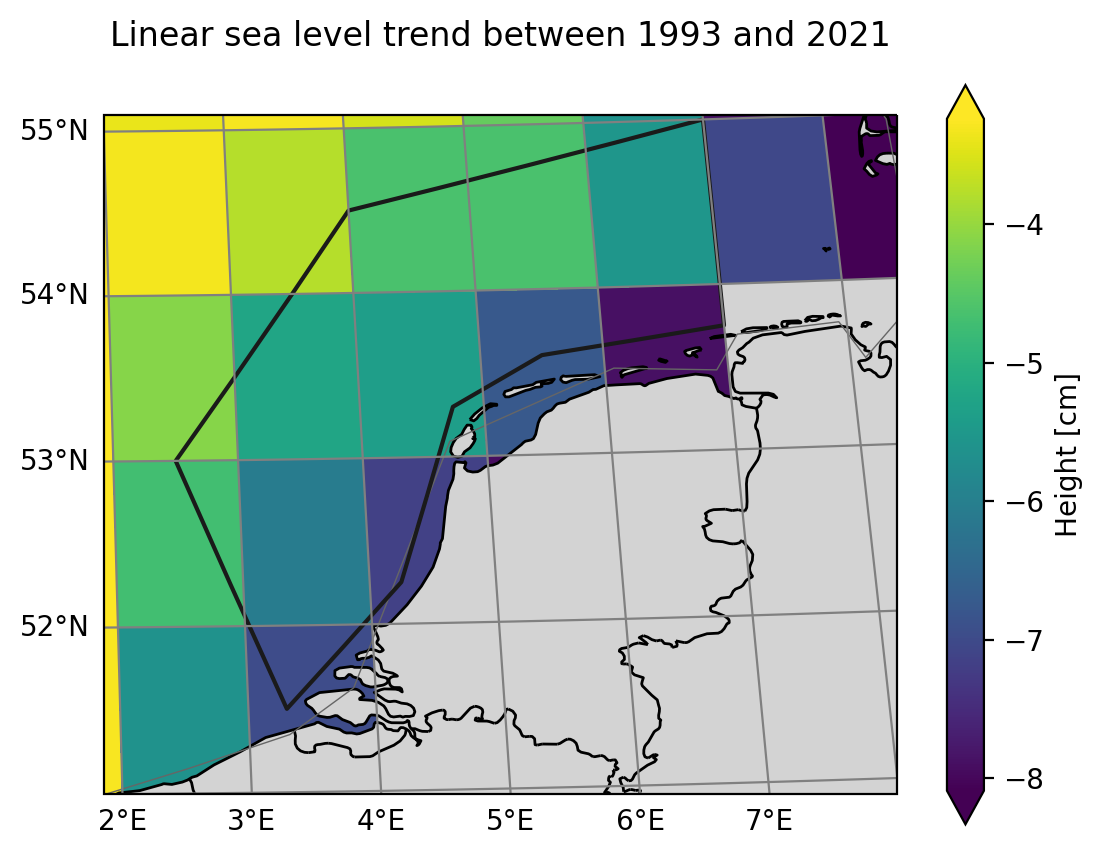

In [14]:
p = ECE3_245_zos.sel(lon=slice(lon_min-1,lon_max+1), 
                       lat=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'Height [cm]'},
    robust=True,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Linear sea level trend between 1993 and 2021', pad=25)

In [15]:
# Define the mask and change its value from 0 to 1
mask_cmip = NLregion.mask_3D(ECE3_245_zos.lon, ECE3_245_zos.lat)


Text(0.5, 1.0, 'Linear sea level trend between 1993 and 2021')

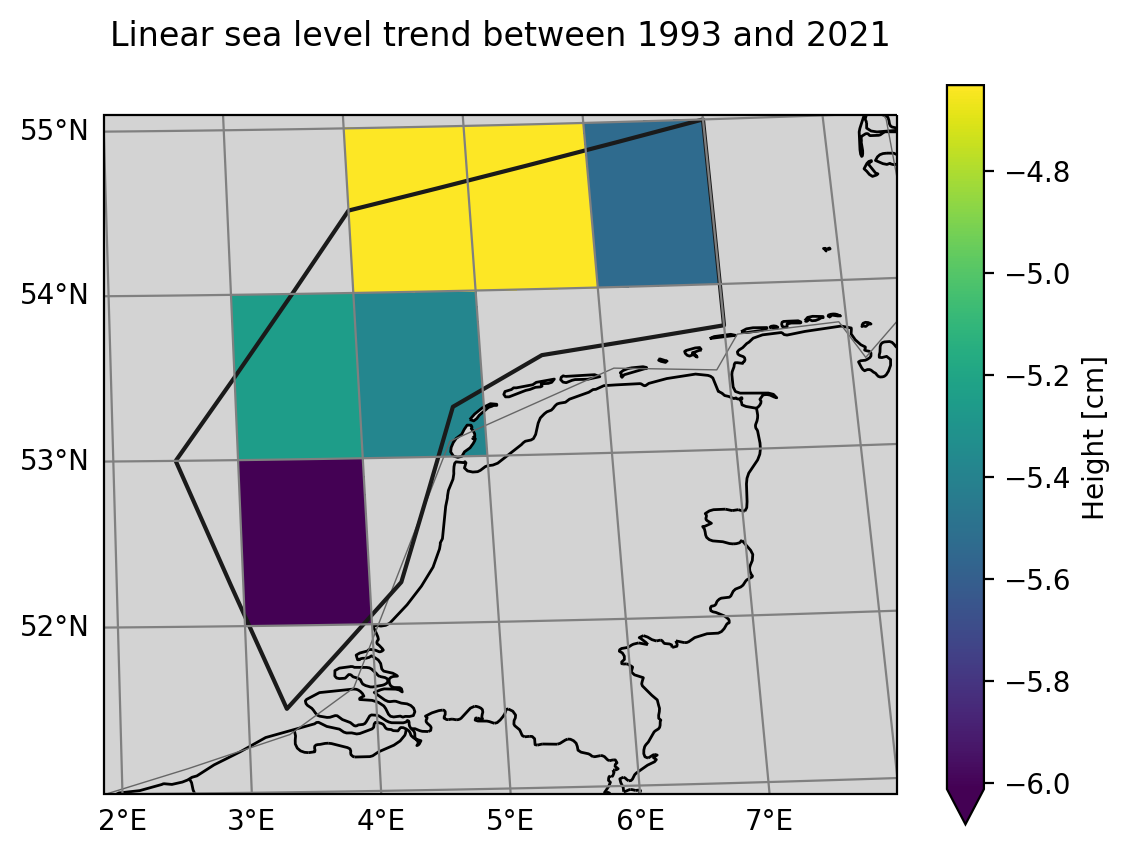

In [16]:
ECE3_245_zos_m = ECE3_245_zos.where(mask_cmip)

p = ECE3_245_zos_m.sel(lon=slice(lon_min-1,lon_max+1), 
                       lat=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'Height [cm]'},
    robust=True,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('Linear sea level trend between 1993 and 2021', pad=25)

In [17]:
ECE3_245_zos_m

<xarray.DataArray 'CorrectedReggrided_zos' (lat: 180, lon: 360, region: 1)>
dask.array<where, shape=(180, 360, 1), dtype=float64, chunksize=(180, 360, 1), chunktype=numpy.ndarray>
Coordinates:
    model    <U9 'EC-Earth3'
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    time     float64 1.9e+03
  * region   (region) int64 0
    abbrevs  (region) <U2 'NL'
    names    (region) <U2 'NL'
Attributes:
    units:              cm
    regridding_method:  xESMF package with bilinear
    branching_method:   unsing_branching_time
    detrending_order:   f{trend_order}

In [18]:
ECE3_245_zos_stacked = ECE3_245_zos_m.isel(region=0).stack(x=['lat','lon'])
points_selected = ECE3_245_zos_stacked[ECE3_245_zos_stacked.notnull()]

In [19]:
for i,j in zip(points_selected.lat.data, points_selected.lon.data):
    print([i,j])

[52.5, 3.5]
[53.5, 3.5]
[53.5, 4.5]
[54.5, 4.5]
[54.5, 5.5]
[54.5, 6.5]


## Prepare region figure for scientific report

In [23]:
# Import information about latitude/longitude of the main tide gauges
tg_id = [20, 22, 23, 24, 25, 32]

# Tide gauge data (rlr_annual) was downloaded from PSMSL: https://psmsl.org/
data_tidegauges_dir = '/Users/dewilebars/Projects/SLBudget/data/'
tg_data_dir = f'{data_tidegauges_dir}rlr_annual'
names_col = ('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality')
filelist_df = pd.read_csv(tg_data_dir + '/filelist.txt', sep=';', 
                          header=None, names=names_col)
filelist_df = filelist_df.set_index('id')

In [140]:
def steric_masks_north_sea(da, mask_name):
    '''Define a few masks to use to compute the steric expansion that is felt 
    in the North Sea.
    The input data array needs to have a latitude/longitude coordinates with
    longitudes from -180 to 180.'''

    if mask_name == 'EBB':
        # Extended bay of Biscay
        mask = xr.where(np.isnan(da[0,:,:,:]
                                 .sel(depth=2000, method='nearest')), np.nan, 1)
        mask = mask.where(mask.lon <= -2)
        mask = mask.where(mask.lon >= -12)
        mask = mask.where(mask.lat <= 52)
        mask = mask.where(mask.lat >= 35)  
        
    elif mask_name == 'NWS':
        # Norwegian Sea
        mask = xr.where(np.isnan(da[0,:,:,:]
                                 .sel(depth=2000, method='nearest')), np.nan, 1)
        mask = mask.where(mask.lon <= 8)
        mask = mask.where(mask.lon >= -10)
        mask = mask.where(mask.lat <= 69)
        mask = mask.where(mask.lat >= 60)
        
    else:
        print('ERROR: mask_name argument is not available')

    del mask['depth']
    del mask['time']
    
    return mask


In [141]:
# Import information about steric sea level masks
#+add depth information
topo_data = '/Users/dewilebars/Data/ETOPO2022/'
topo_ds = xr.open_dataset(f'{topo_data}ETOPO_2022_v1_60s_N90W180_bed.nc')

dens_path = '/Users/dewilebars/Projects/SLBudget/data/DataSteric/'
DENS = xr.open_dataset(f'{dens_path}density_teos10_en422_g10_1900_2022.nc')

In [172]:
lon_min, lon_max, lat_min, lat_max = -30, 30, 30, 70
topo_sel = topo_ds.z.sel(lon=slice(lon_min-1,lon_max+1), 
                         lat=slice(lat_min,lat_max+1))
topo_sel = topo_sel.where(topo_sel<0, np.nan)

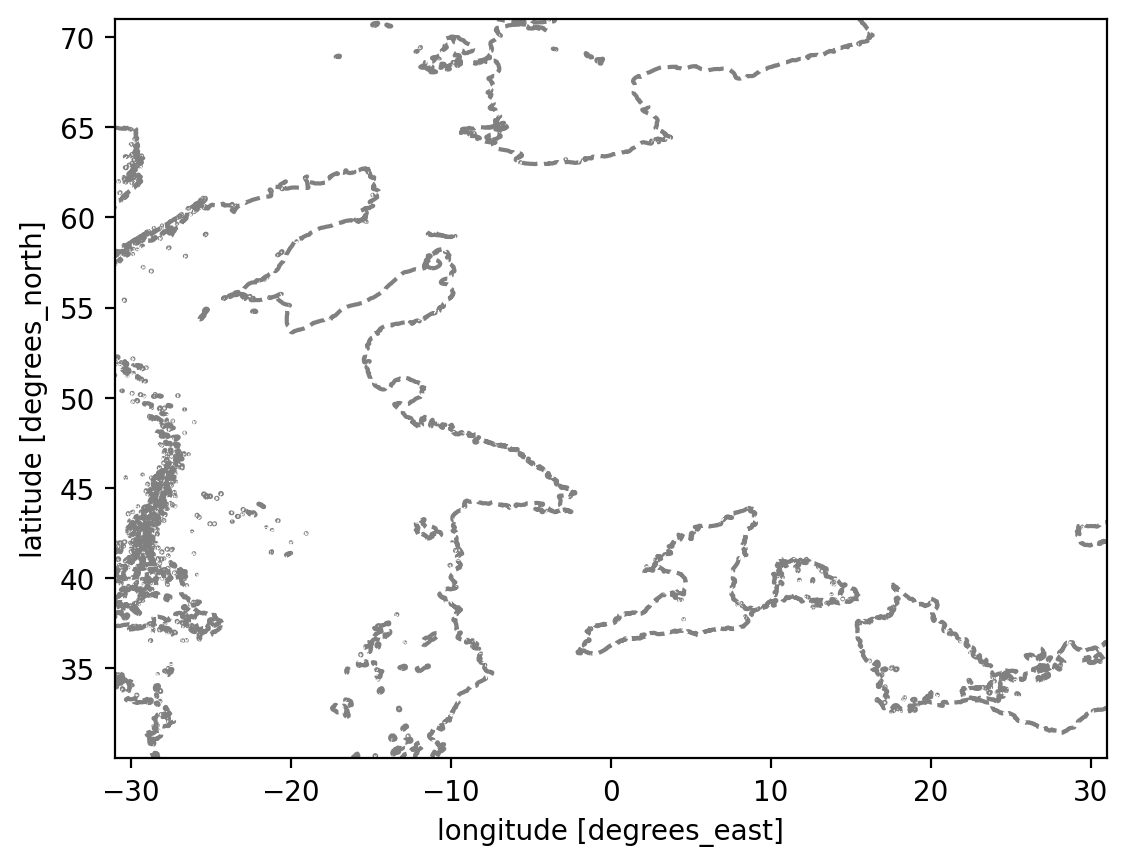

In [173]:
topo_sel.plot.contour(levels=[-2000], colors='grey')

In [174]:
mask_EBB = steric_masks_north_sea(DENS.density, 'EBB')
mask_NWS = steric_masks_north_sea(DENS.density, 'NWS')

new_mask_NWS = xr.where(mask_NWS==1,1,0)
new_mask_EBB = xr.where(mask_EBB==1,1,0)

new_mask = new_mask_NWS + new_mask_EBB
new_mask = xr.where(new_mask==1,1,np.nan)

#new_mask_NWS = mask_NWS.where(mask_NWS==1,1,0)

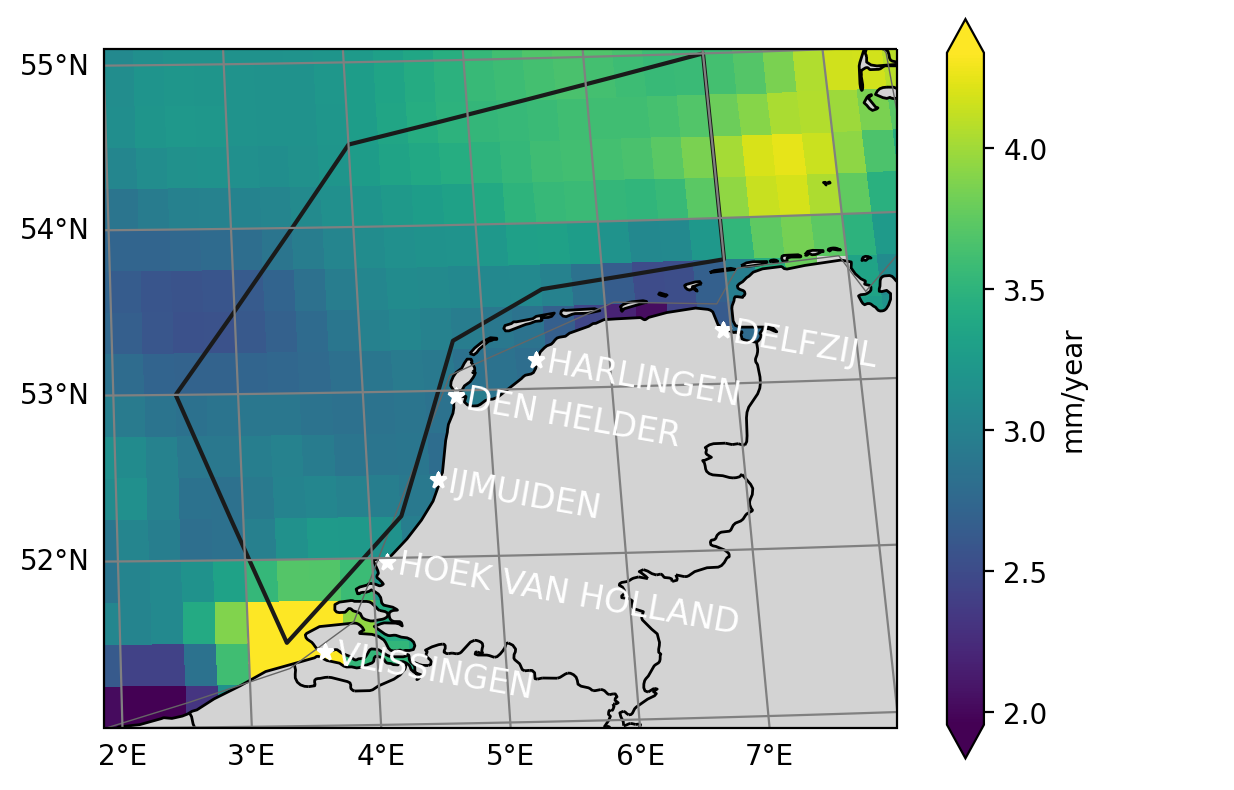

In [185]:
lon_min, lon_max, lat_min, lat_max = 2, 8, 51, 55

p = rate.sel(longitude=slice(lon_min-1,lon_max+1), 
             latitude=slice(lat_min,lat_max+1)).plot(
    subplot_kws=dict(projection=ccrs.LambertAzimuthalEqualArea(), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'label':'mm/year'},
    robust=True,
    zorder=0)

cols = 'white'

for i in tg_id:
    tg = filelist_df.loc[i]
    plt.plot(tg.lon, tg.lat, color=cols, marker='*', 
             linestyle='None', transform=ccrs.PlateCarree(),)
    plt.text(tg.lon, tg.lat, tg.loc['name'], color=cols, 
             horizontalalignment='left',
             verticalalignment='center',
             rotation=-10,
             rotation_mode='anchor',
             transform=ccrs.PlateCarree(), fontsize=12)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

NLregion.plot(add_label=False)

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
plt.title('')

plt.savefig(f'figures/TrendAltimetry_Netherlands.pdf' ,dpi=150)

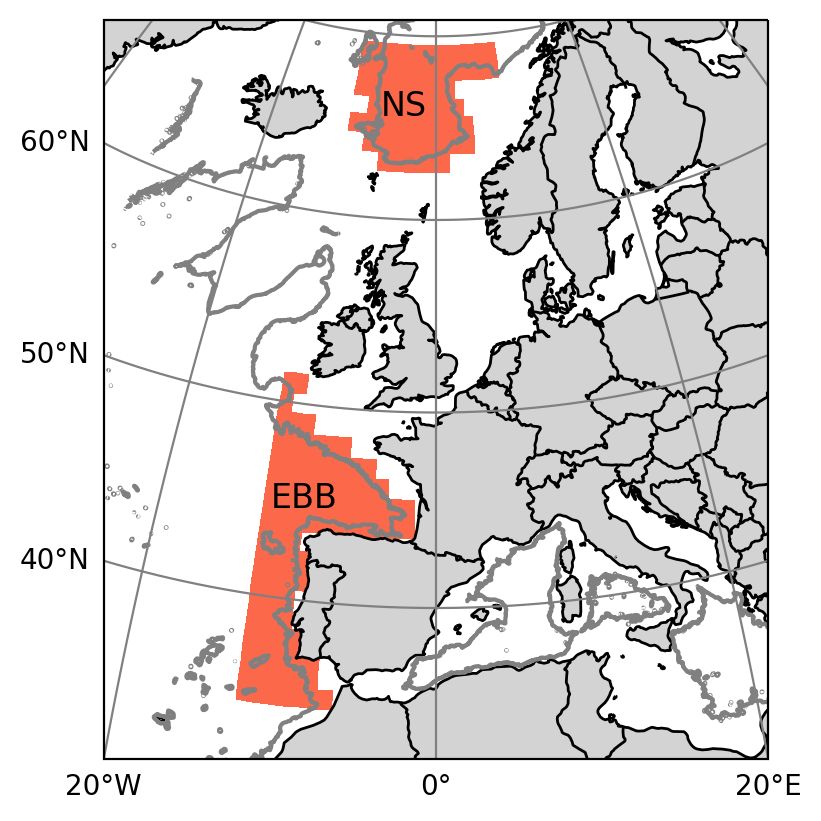

In [187]:
ax = plt.subplot(projection=ccrs.Orthographic(0, 45))

lon_min, lon_max, lat_min, lat_max = -20, 20, 30, 70

p = new_mask.plot( 
    transform=ccrs.PlateCarree(),
    cmap='Reds',
    add_colorbar=False,
    zorder=0,
    ax=ax)

topo_sel.plot.contour(levels=[-2000], 
                      colors='grey', 
                      linestyles=['-'],
                      transform=ccrs.PlateCarree(), 
                      ax=ax)

plt.text(-12, 45, "EBB", color="Black", 
         horizontalalignment='left',
         verticalalignment='center',
         transform=ccrs.PlateCarree(), fontsize=12)

plt.text(-7, 66, "NS", color="Black", 
         horizontalalignment='left',
         verticalalignment='center',
         transform=ccrs.PlateCarree(), fontsize=12)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)
p.axes.add_feature(cfeature.OCEAN, facecolor='white')
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])

plt.savefig('./figures/StericMaskRegion.pdf', dpi=150)